In [1]:
! git clone https://github.com/gpauloski/kfac_pytorch.git
! pip install ./kfac_pytorch

fatal: destination path 'kfac_pytorch' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Processing ./kfac_pytorch
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for kfac-pytorch: filename=kfac_pytorch-0.4.1-py2.py3-none-any.whl size=46268 sha256=96c2aee54aaa4a4dc17ac2ee9a2e35d24f947d2bbf966d042ff5351b80eed521
  Stored in directory: /tmp/pip-ephem-wheel-cache-e9z7_ymu/wheels/02/e3/8d/9cea3dc920ea6134a9a6010384a614c48802250e8ad04710e0
Successfully built kfac-pytorch


In [2]:
from kfac.preconditioner import KFACPreconditioner

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from itertools import product
from torch import tensor
import pickle
import time 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [6]:
resume = True

if resume: 
    with open('kfc_big_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_kfc = arr["acc"]
        test_loss_history_kfc = arr["loss"]
        loss_in_training_kfc = arr["loss_train"]
        time_learning_kfc = arr["time"]
else:
    test_accuracy_history_kfc, test_loss_history_kfc, loss_in_training_kfc, time_learning_kfc = {}, {}, {}, {}

In [7]:
test_accuracy_history_kfc

{(0.1, 0.001): [0.5026,
  0.669,
  0.7336,
  0.7626,
  0.7938,
  0.8048,
  0.8182,
  0.8258,
  0.8312,
  0.8214,
  0.83,
  0.819,
  0.8304,
  0.824,
  0.835,
  0.8296,
  0.8412,
  0.8314,
  0.8352,
  0.8342],
 (0.1, 0.0003): [0.5046,
  0.677,
  0.7212,
  0.794,
  0.8024,
  0.7992,
  0.816,
  0.8088,
  0.8122,
  0.821,
  0.8142,
  0.8196,
  0.8206,
  0.8214,
  0.8124,
  0.8368,
  0.8274,
  0.823,
  0.8212,
  0.8178],
 (0.1, 0.0001): [0.518,
  0.6664,
  0.7422,
  0.7864,
  0.7966,
  0.8026,
  0.8034,
  0.803,
  0.8062,
  0.8158,
  0.8274,
  0.8222,
  0.818,
  0.8162,
  0.815,
  0.8144,
  0.82,
  0.8258,
  0.823,
  0.8238],
 (0.1, 0): [0.5132,
  0.65,
  0.7302,
  0.7804,
  0.7962,
  0.8086,
  0.796,
  0.8096,
  0.8102,
  0.8124,
  0.8116,
  0.812,
  0.8242,
  0.8106,
  0.8242,
  0.8224,
  0.809,
  0.8286,
  0.8296,
  0.8192],
 (0.03, 0.001): [0.5384,
  0.6612,
  0.709,
  0.7526,
  0.7548,
  0.7558,
  0.7586,
  0.7584,
  0.767,
  0.7646,
  0.7706,
  0.7668,
  0.7662,
  0.7836,
  0.78,
  0.

In [7]:
for learning_rate, weight_decay in product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0]):
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_kfc:
        print("Already computed, ignoring")
        continue
    
    lenet = torchvision.models.resnet18(pretrained=False)
    lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    lenet.maxpool = torch.nn.Identity()
    lenet.cuda()
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(lenet.parameters(), lr=learning_rate, weight_decay=weight_decay)
    preconditioner = KFACPreconditioner(lenet)
    
    test_loss_history_kfc[key] = list()
    test_accuracy_history_kfc[key] = list()
    loss_in_training_kfc[key] = list()
    time_learning_kfc[key] = list()

    for epoch in range(20):
        
        sum_los = 0
        start_time = time.time()
        
        for i, data in enumerate(trainloader, 0):
            
            optimizer.zero_grad()

            X_batch, y_batch = data
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            preds = lenet.forward(X_batch)

            loss_value = loss(preds, y_batch)
            print('los', i, ':', loss_value)
            loss_value.backward()
            sum_los += float(loss_value)
            try:
                preconditioner.step()
                optimizer.step()
            except:
                print("Optimizer or preconditioner step failed")
                pass
        
        time_learning_kfc[key].append(time.time() - start_time)
        loss_in_training_kfc[key].append(sum_los/450)
        
        correct = 0
        total = 0
        los = 0
        
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = lenet.forward(images)
                outputs = outputs.cuda()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                loss_value = loss(outputs, labels)
                total += labels.size(0)
                los += loss_value
                print('los in test:', loss_value)
                
        
        test_loss_history_kfc[key].append(los/50)
        print('los epoch', epoch, ':', los/50)
    
        test_accuracy_history_kfc[key].append(correct/total)
        print('accuracy epoch', epoch, ':', correct/total)
    
    print(test_accuracy_history_kfc[(learning_rate, weight_decay)])
    print(loss_in_training_kfc[(learning_rate, weight_decay)])
    with open('kfc_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_kfc, "loss": test_loss_history_kfc, "loss_train":loss_in_training_kfc, "time":time_learning_kfc}, f)

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


In [8]:
test_accuracy_history_kfc

{(0.1, 0.001): [0.5026,
  0.669,
  0.7336,
  0.7626,
  0.7938,
  0.8048,
  0.8182,
  0.8258,
  0.8312,
  0.8214,
  0.83,
  0.819,
  0.8304,
  0.824,
  0.835,
  0.8296,
  0.8412,
  0.8314,
  0.8352,
  0.8342],
 (0.1, 0.0003): [0.5046,
  0.677,
  0.7212,
  0.794,
  0.8024,
  0.7992,
  0.816,
  0.8088,
  0.8122,
  0.821,
  0.8142,
  0.8196,
  0.8206,
  0.8214,
  0.8124,
  0.8368,
  0.8274,
  0.823,
  0.8212,
  0.8178],
 (0.1, 0.0001): [0.518,
  0.6664,
  0.7422,
  0.7864,
  0.7966,
  0.8026,
  0.8034,
  0.803,
  0.8062,
  0.8158,
  0.8274,
  0.8222,
  0.818,
  0.8162,
  0.815,
  0.8144,
  0.82,
  0.8258,
  0.823,
  0.8238],
 (0.1, 0): [0.5132,
  0.65,
  0.7302,
  0.7804,
  0.7962,
  0.8086,
  0.796,
  0.8096,
  0.8102,
  0.8124,
  0.8116,
  0.812,
  0.8242,
  0.8106,
  0.8242,
  0.8224,
  0.809,
  0.8286,
  0.8296,
  0.8192],
 (0.03, 0.001): [0.5384,
  0.6612,
  0.709,
  0.7526,
  0.7548,
  0.7558,
  0.7586,
  0.7584,
  0.767,
  0.7646,
  0.7706,
  0.7668,
  0.7662,
  0.7836,
  0.78,
  0.

In [ ]:
for learning_rate in [0.5, 1]:
    key = 'schedule_' + str(learning_rate)
    if key in test_accuracy_history_kfc:
        print("Already computed, ignoring")
        continue
    
    lenet = torchvision.models.resnet18(pretrained=False)
    lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    lenet.maxpool = torch.nn.Identity()
    lenet.cuda()
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(lenet.parameters(), lr=learning_rate, weight_decay=0.001)
    preconditioner = KFACPreconditioner(lenet)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    test_loss_history_kfc[key] = list()
    test_accuracy_history_kfc[key] = list()
    loss_in_training_kfc[key] = list()
    time_learning_kfc[key] = list()

    for epoch in tqdm(range(20)):
        
        sum_los = 0
        start_time = time.time()
        
        for i, data in enumerate(trainloader, 0):
            
            optimizer.zero_grad()

            X_batch, y_batch = data
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            preds = lenet.forward(X_batch)

            loss_value = loss(preds, y_batch)
            # print('los', i, ':', loss_value)
            loss_value.backward()
            sum_los += float(loss_value)
            try:
                preconditioner.step()
                optimizer.step()
            except:
                print("Optimizer or preconditioner step failed")
                pass
        
        scheduler.step()
        time_learning_kfc[key].append(time.time() - start_time)
        loss_in_training_kfc[key].append(sum_los/450)
        
        correct = 0
        total = 0
        los = 0
        
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = lenet.forward(images)
                outputs = outputs.cuda()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                loss_value = loss(outputs, labels)
                total += labels.size(0)
                los += loss_value
                # print('los in test:', loss_value)
                
        
        test_loss_history_kfc[key].append(los/50)
        print('los epoch', epoch, ':', los/50)
    
        test_accuracy_history_kfc[key].append(correct/total)
        print('accuracy epoch', epoch, ':', correct/total)
    
    print(test_accuracy_history_kfc[key])
    print(loss_in_training_kfc[key])
    with open('kfc_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_kfc, "loss": test_loss_history_kfc, "loss_train":loss_in_training_kfc, "time":time_learning_kfc}, f)

  5%|▌         | 1/20 [15:43<4:58:40, 943.17s/it]

los epoch 0 : tensor(1.8284, device='cuda:0')
accuracy epoch 0 : 0.3402


 10%|█         | 2/20 [32:12<4:51:01, 970.10s/it]

los epoch 1 : tensor(1.4244, device='cuda:0')
accuracy epoch 1 : 0.5178


 15%|█▌        | 3/20 [49:00<4:39:49, 987.59s/it]

los epoch 2 : tensor(0.9423, device='cuda:0')
accuracy epoch 2 : 0.6746


 20%|██        | 4/20 [1:06:02<4:27:00, 1001.26s/it]

los epoch 3 : tensor(0.7378, device='cuda:0')
accuracy epoch 3 : 0.7564


 25%|██▌       | 5/20 [1:23:16<4:13:15, 1013.02s/it]

los epoch 4 : tensor(0.6215, device='cuda:0')
accuracy epoch 4 : 0.7908


 30%|███       | 6/20 [1:40:38<3:58:41, 1022.99s/it]

los epoch 5 : tensor(0.5960, device='cuda:0')
accuracy epoch 5 : 0.7942


 35%|███▌      | 7/20 [1:58:08<3:43:31, 1031.64s/it]

los epoch 6 : tensor(0.6004, device='cuda:0')
accuracy epoch 6 : 0.806


 40%|████      | 8/20 [2:15:45<3:27:55, 1039.59s/it]

los epoch 7 : tensor(0.5695, device='cuda:0')
accuracy epoch 7 : 0.8182


 45%|████▌     | 9/20 [2:33:27<3:11:54, 1046.82s/it]

los epoch 8 : tensor(0.5954, device='cuda:0')
accuracy epoch 8 : 0.8202


 50%|█████     | 10/20 [2:51:13<2:55:25, 1052.58s/it]

los epoch 9 : tensor(0.5811, device='cuda:0')
accuracy epoch 9 : 0.8308


 55%|█████▌    | 11/20 [3:08:58<2:38:29, 1056.61s/it]

los epoch 10 : tensor(0.6274, device='cuda:0')
accuracy epoch 10 : 0.8286
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed


 60%|██████    | 12/20 [3:26:41<2:21:06, 1058.37s/it]

los epoch 11 : tensor(0.6753, device='cuda:0')
accuracy epoch 11 : 0.824


 65%|██████▌   | 13/20 [3:44:29<2:03:49, 1061.40s/it]

los epoch 12 : tensor(0.7287, device='cuda:0')
accuracy epoch 12 : 0.825


 70%|███████   | 14/20 [4:02:19<1:46:22, 1063.83s/it]

los epoch 13 : tensor(0.7112, device='cuda:0')
accuracy epoch 13 : 0.8372


 75%|███████▌  | 15/20 [4:20:09<1:28:48, 1065.68s/it]

los epoch 14 : tensor(0.7955, device='cuda:0')
accuracy epoch 14 : 0.8396


 80%|████████  | 16/20 [4:37:59<1:11:08, 1067.02s/it]

los epoch 15 : tensor(0.7920, device='cuda:0')
accuracy epoch 15 : 0.85
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed


 85%|████████▌ | 17/20 [4:55:27<53:04, 1061.38s/it]  

los epoch 16 : tensor(0.7809, device='cuda:0')
accuracy epoch 16 : 0.8554
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimi

 90%|█████████ | 18/20 [5:11:42<34:30, 1035.50s/it]

los epoch 17 : tensor(0.7944, device='cuda:0')
accuracy epoch 17 : 0.8564
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimi

 95%|█████████▌| 19/20 [5:26:11<16:25, 985.29s/it] 

los epoch 18 : tensor(0.7781, device='cuda:0')
accuracy epoch 18 : 0.8594
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimi

100%|██████████| 20/20 [5:38:44<00:00, 1016.21s/it]


los epoch 19 : tensor(0.7953, device='cuda:0')
accuracy epoch 19 : 0.8562
[0.3402, 0.5178, 0.6746, 0.7564, 0.7908, 0.7942, 0.806, 0.8182, 0.8202, 0.8308, 0.8286, 0.824, 0.825, 0.8372, 0.8396, 0.85, 0.8554, 0.8564, 0.8594, 0.8562]
[2.7976758125093246, 1.5132657893498738, 1.0385418102476331, 0.7801432738039229, 0.6244352107577854, 0.4956135025289324, 0.39561818927526476, 0.30475487252076466, 0.23212615396413538, 0.17450099722378784, 0.126091182778279, 0.09070386552769277, 0.05909683328846262, 0.03536925352049164, 0.018757815349510768, 0.007449981478405082, 0.0020592836150576154, 0.0007149422667498584, 0.0002215130670123876, 0.00019608350665293984]


  5%|▌         | 1/20 [15:39<4:57:37, 939.85s/it]

los epoch 0 : tensor(2.5070, device='cuda:0')
accuracy epoch 0 : 0.24


In [10]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

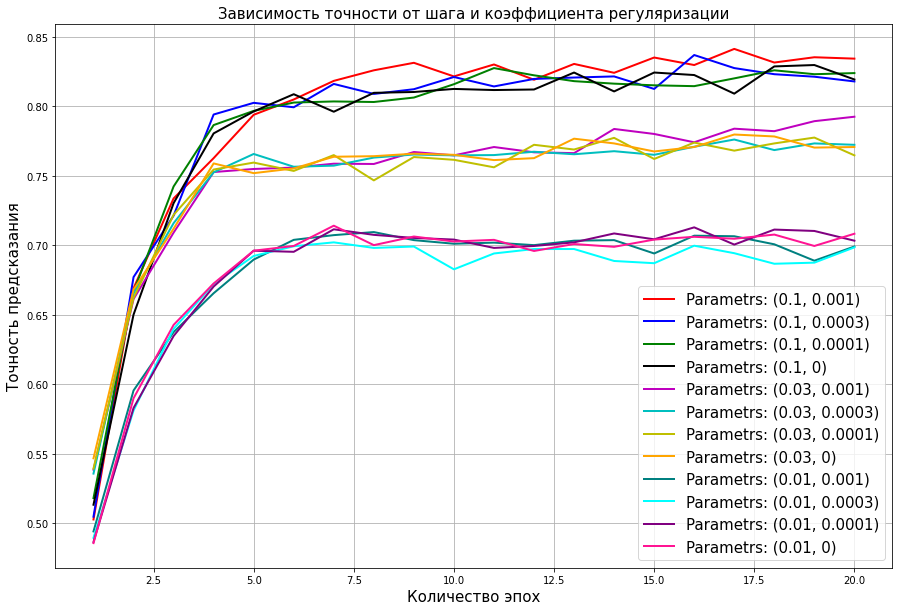

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_kfc.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('kfc_2_accrucy.png')

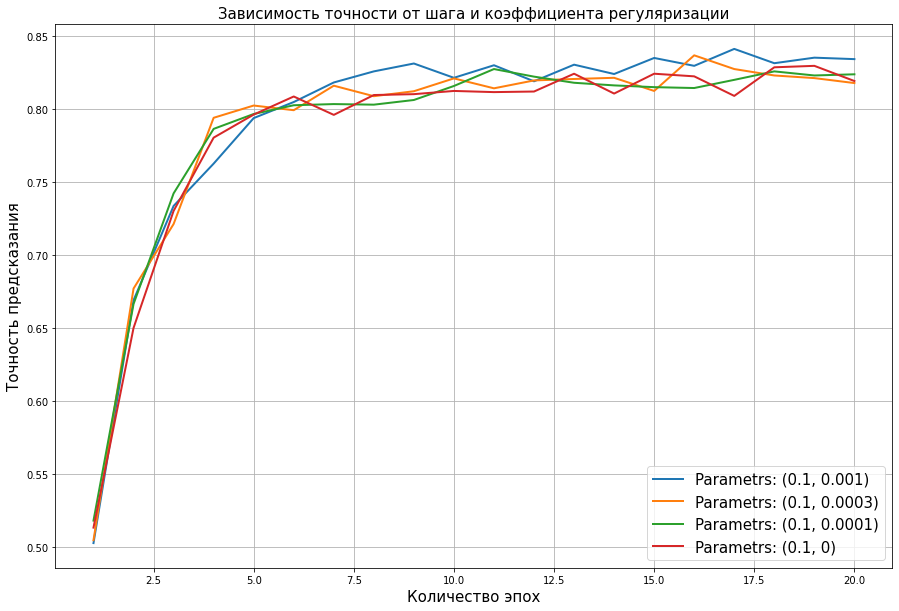

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for  param in product([0.1], [1e-3, 3e-4, 1e-4, 0]):
    plt.plot(range(1, 21), test_accuracy_history_kfc[param], label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('kfc_2_accrucy_small.png')

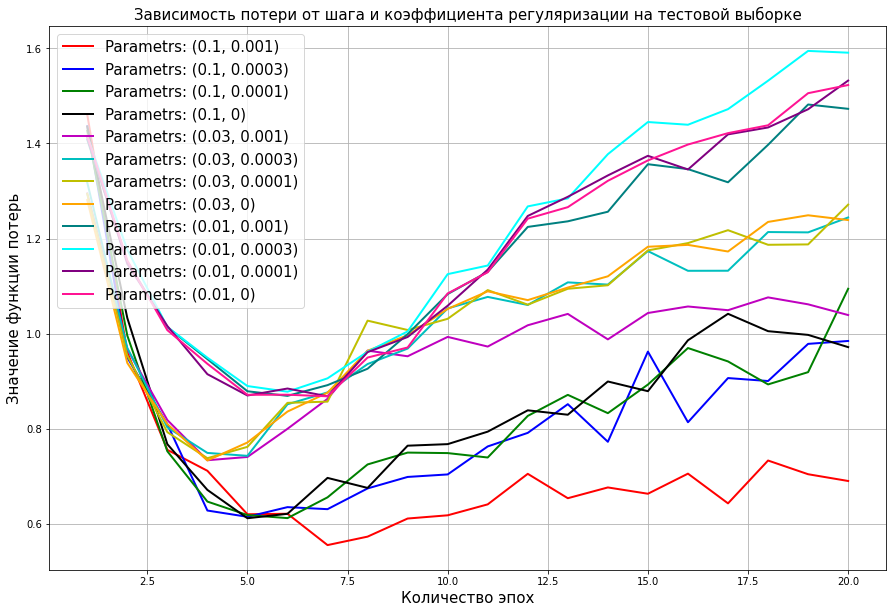

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_kfc.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('kfc_2_loss.png')

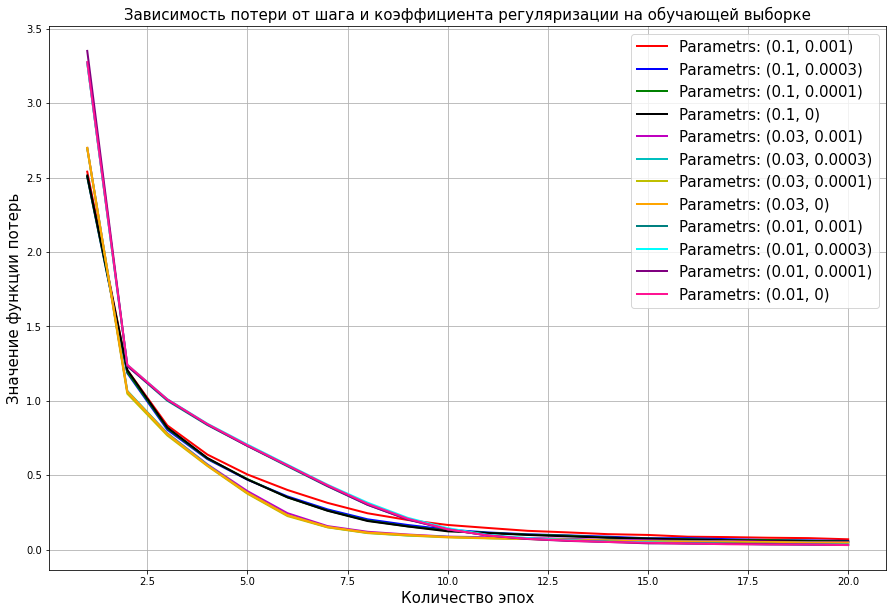

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_kfc.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('kfc_2_loss_train.png')

In [ ]:
time_learning_kfc

{(0.1, 0.001): [970.7009749412537,
  1001.913462638855,
  1010.7917008399963,
  1015.5354254245758,
  1020.0400712490082,
  1024.33394241333,
  1027.706670999527,
  1030.756456375122,
  1032.567863225937,
  1032.2721183300018,
  1035.5260519981384,
  1036.3022165298462,
  1036.78737282753,
  1037.8724267482758,
  1039.0060625076294,
  1041.0136651992798,
  1040.191069841385,
  1040.466511964798,
  1040.5812888145447,
  1040.96462392807],
 (0.1, 0.0003): [970.0250689983368,
  1003.6021223068237,
  1010.6358630657196,
  1014.0807871818542,
  1019.2033479213715,
  1024.2107264995575,
  1026.3007006645203,
  1027.3156127929688,
  1024.8881907463074,
  1019.3370068073273,
  991.9052677154541,
  963.8541874885559,
  1003.2024178504944,
  993.4236166477203,
  956.7088379859924,
  994.402449131012,
  984.5426621437073,
  985.0942273139954,
  985.2670757770538,
  993.7927143573761],
 (0.1, 0.0001): [970.9002208709717,
  1001.2414538860321,
  1007.5537157058716,
  1012.0972888469696,
  1015.0116

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [ ]:
resume = True

if resume: 
    with open('kfc_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_kfc = arr["acc"]
        test_loss_history_kfc = arr["loss"]
        loss_in_training_kfc = arr["loss_train"]
        time_learning_kfc = arr["time"]
else:
    test_accuracy_history_kfc, test_loss_history_kfc, loss_in_training_kfc, time_learning_kfc = {}, {}, {}, {}

In [6]:
import tqdm

In [ ]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(lenet.parameters(), lr=0.1, weight_decay=0.001)
preconditioner = KFACPreconditioner(lenet)

test_loss_history_kfc = list()
test_accuracy_history_kfc = list()
loss_in_training_kfc = list()
time_learning_kfc = list()

for epoch in tqdm.tqdm(range(20)):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        # print('los', i, ':', loss_value)
        loss_value.backward()
        sum_los += float(loss_value)
        try:
            preconditioner.step()
            optimizer.step()
        except:
            print("Optimizer or preconditioner step failed")
            pass

    time_learning_kfc.append(time.time() - start_time)
    loss_in_training_kfc.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value
            # print('los in test:', loss_value)


    test_loss_history_kfc.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_kfc.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_kfc)
print(loss_in_training_kfc)
with open('kfc_bresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_kfc, "loss": test_loss_history_kfc, "loss_train":loss_in_training_kfc, "time":time_learning_kfc}, f)

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [9]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(lenet.parameters(), lr=0.1, weight_decay=0.001)
preconditioner = KFACPreconditioner(lenet)

test_loss_history_kfc = list()
test_accuracy_history_kfc = list()
loss_in_training_kfc = list()
time_learning_kfc = list()

test_accuracy = 0

while test_accuracy <= 0.75:

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        # print('los', i, ':', loss_value)
        loss_value.backward()
        sum_los += float(loss_value)
        try:
            preconditioner.step()
            optimizer.step()
        except:
            print("Optimizer or preconditioner step failed")
            pass

    time_learning_kfc.append(time.time() - start_time)
    loss_in_training_kfc.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value
            # print('los in test:', loss_value)


    test_loss_history_kfc.append(los/100)
    print('los epoch:', los/100)
    
    test_accuracy = correct/total
    test_accuracy_history_kfc.append(test_accuracy)
    print('accuracy epoch:', test_accuracy)

print(test_accuracy_history_kfc)
print(loss_in_training_kfc)
with open('kfc_bresults_75.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_kfc, "loss": test_loss_history_kfc, "loss_train":loss_in_training_kfc, "time":time_learning_kfc}, f)

los epoch: tensor(1.4170, device='cuda:0')
accuracy epoch: 0.4877
los epoch: tensor(0.9367, device='cuda:0')
accuracy epoch: 0.6751
los epoch: tensor(0.7076, device='cuda:0')
accuracy epoch: 0.7569
[0.4877, 0.6751, 0.7569]
[2.5067233580610027, 1.14688077011834, 0.7841583746930827]


In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [12]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(lenet.parameters(), lr=0.5, weight_decay=0.001)
preconditioner = KFACPreconditioner(lenet)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

test_loss_history_kfc = list()
test_accuracy_history_kfc = list()
loss_in_training_kfc = list()
time_learning_kfc = list()

for epoch in tqdm.tqdm(range(20)):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        # print('los', i, ':', loss_value)
        loss_value.backward()
        sum_los += float(loss_value)
        try:
            preconditioner.step()
            optimizer.step()
        except:
            print("Optimizer or preconditioner step failed")
            pass

    scheduler.step()
    time_learning_kfc.append(time.time() - start_time)
    loss_in_training_kfc.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value
            # print('los in test:', loss_value)


    test_loss_history_kfc.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_kfc.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_kfc)
print(loss_in_training_kfc)
with open('kfc_bresults_scheduler.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_kfc, "loss": test_loss_history_kfc, "loss_train":loss_in_training_kfc, "time":time_learning_kfc}, f)

  5%|▌         | 1/20 [15:40<4:57:52, 940.64s/it]

los epoch 0 : tensor(1.9878, device='cuda:0')
accuracy epoch 0 : 0.3354


 10%|█         | 2/20 [32:05<4:50:02, 966.78s/it]

los epoch 1 : tensor(1.2583, device='cuda:0')
accuracy epoch 1 : 0.5647


 15%|█▌        | 3/20 [48:48<4:38:37, 983.37s/it]

los epoch 2 : tensor(1.0226, device='cuda:0')
accuracy epoch 2 : 0.6542


 20%|██        | 4/20 [1:05:43<4:25:29, 995.60s/it]

los epoch 3 : tensor(0.7931, device='cuda:0')
accuracy epoch 3 : 0.7259


 25%|██▌       | 5/20 [1:22:48<4:11:32, 1006.19s/it]

los epoch 4 : tensor(0.7002, device='cuda:0')
accuracy epoch 4 : 0.7631


 30%|███       | 6/20 [1:40:01<3:56:55, 1015.40s/it]

los epoch 5 : tensor(0.6622, device='cuda:0')
accuracy epoch 5 : 0.7777


 35%|███▌      | 7/20 [1:57:24<3:41:59, 1024.55s/it]

los epoch 6 : tensor(0.5499, device='cuda:0')
accuracy epoch 6 : 0.819


 40%|████      | 8/20 [2:14:55<3:26:34, 1032.85s/it]

los epoch 7 : tensor(0.5421, device='cuda:0')
accuracy epoch 7 : 0.8205


 45%|████▌     | 9/20 [2:32:33<3:10:48, 1040.75s/it]

los epoch 8 : tensor(0.5741, device='cuda:0')
accuracy epoch 8 : 0.8159


 50%|█████     | 10/20 [2:50:16<2:54:35, 1047.57s/it]

los epoch 9 : tensor(0.5696, device='cuda:0')
accuracy epoch 9 : 0.829


 55%|█████▌    | 11/20 [3:08:01<2:37:57, 1053.04s/it]

los epoch 10 : tensor(0.6157, device='cuda:0')
accuracy epoch 10 : 0.8306


 60%|██████    | 12/20 [3:25:48<2:20:58, 1057.26s/it]

los epoch 11 : tensor(0.6479, device='cuda:0')
accuracy epoch 11 : 0.8225


 65%|██████▌   | 13/20 [3:43:37<2:03:44, 1060.65s/it]

los epoch 12 : tensor(0.6563, device='cuda:0')
accuracy epoch 12 : 0.8396


 70%|███████   | 14/20 [4:01:26<1:46:20, 1063.41s/it]

los epoch 13 : tensor(0.6972, device='cuda:0')
accuracy epoch 13 : 0.8372


 75%|███████▌  | 15/20 [4:19:17<1:28:47, 1065.58s/it]

los epoch 14 : tensor(0.6963, device='cuda:0')
accuracy epoch 14 : 0.8468
Optimizer or preconditioner step failed


 80%|████████  | 16/20 [4:37:07<1:11:07, 1066.78s/it]

los epoch 15 : tensor(0.7521, device='cuda:0')
accuracy epoch 15 : 0.8548
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed


 85%|████████▌ | 17/20 [4:54:26<52:55, 1058.66s/it]  

los epoch 16 : tensor(0.7397, device='cuda:0')
accuracy epoch 16 : 0.86
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimize

 90%|█████████ | 18/20 [5:10:34<34:22, 1031.32s/it]

los epoch 17 : tensor(0.7371, device='cuda:0')
accuracy epoch 17 : 0.8642
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimi

 95%|█████████▌| 19/20 [5:26:55<16:56, 1016.08s/it]

los epoch 18 : tensor(0.7322, device='cuda:0')
accuracy epoch 18 : 0.8667
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimizer or preconditioner step failed
Optimi

100%|██████████| 20/20 [5:43:35<00:00, 1030.76s/it]

los epoch 19 : tensor(0.7307, device='cuda:0')
accuracy epoch 19 : 0.8669
[0.3354, 0.5647, 0.6542, 0.7259, 0.7631, 0.7777, 0.819, 0.8205, 0.8159, 0.829, 0.8306, 0.8225, 0.8396, 0.8372, 0.8468, 0.8548, 0.86, 0.8642, 0.8667, 0.8669]
[2.766578308654868, 1.5103198533472808, 1.0664522137330925, 0.8150900266092757, 0.6541657046779342, 0.5290586806509806, 0.43457742861431575, 0.3494124423550523, 0.2685028478341258, 0.20178841857806495, 0.14763223431680514, 0.10282666888492911, 0.0664324275440658, 0.04284865625972009, 0.022632500281020918, 0.010421486962181719, 0.0030598494472186483, 0.000715218251179581, 0.0002653143522959157, 0.00016578497075976845]


In [ ]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(lenet.parameters(), lr=0.5, weight_decay=0.001)
preconditioner = KFACPreconditioner(lenet)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

test_loss_history_kfc[key] = list()
test_accuracy_history_kfc[key] = list()
loss_in_training_kfc[key] = list()
time_learning_kfc[key] = list()

for epoch in tqdm(range(20)):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        # print('los', i, ':', loss_value)
        loss_value.backward()
        sum_los += float(loss_value)
        try:
            preconditioner.step()
            optimizer.step()
        except:
            print("Optimizer or preconditioner step failed")
            pass

    scheduler.step()
    time_learning_kfc[key].append(time.time() - start_time)
    loss_in_training_kfc[key].append(sum_los/450)

    correct = 0
    total = 0
    los = 0

    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value
            # print('los in test:', loss_value)


    test_loss_history_kfc[key].append(los/50)
    print('los epoch', epoch, ':', los/50)

    test_accuracy_history_kfc[key].append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_kfc[key])
print(loss_in_training_kfc[key])
with open('kfc_bresults_scheduler.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_kfc, "loss": test_loss_history_kfc, "loss_train":loss_in_training_kfc, "time":time_learning_kfc}, f)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
with open('adam_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_adam = arr["acc"]
        test_loss_history_adam = arr["loss"]
        loss_in_training_adam = arr["loss_train"]
        time_learning_adam = arr["time"]
        
with open('sgd_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sgd = arr["acc"]
        test_loss_history_sgd = arr["loss"]
        loss_in_training_sgd = arr["loss_train"]
        time_learning_sgd = arr["time"]

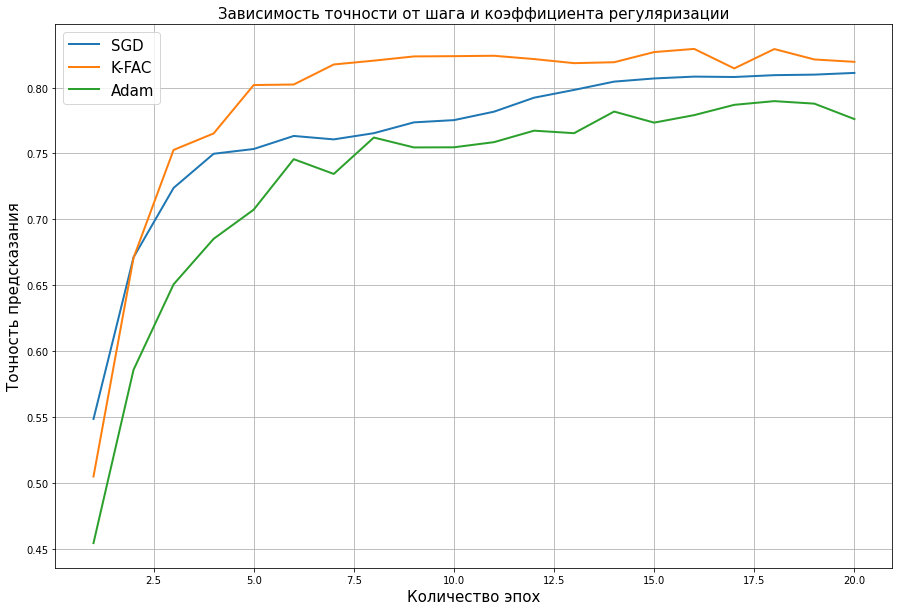

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)


plt.plot(range(1, 21), test_accuracy_history_sgd, label = 'SGD', linewidth=2)
plt.plot(range(1, 21), test_accuracy_history_kfc, label = 'K-FAC', linewidth=2)
plt.plot(range(1, 21), test_accuracy_history_adam, label = 'Adam', linewidth=2)

plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('exp_2_accrucy.png')

In [ ]:
test_loss_history_sgd

[tensor(1.2309, device='cuda:0'),
 tensor(0.9412, device='cuda:0'),
 tensor(0.7846, device='cuda:0'),
 tensor(0.7411, device='cuda:0'),
 tensor(0.7505, device='cuda:0'),
 tensor(0.7790, device='cuda:0'),
 tensor(0.8887, device='cuda:0'),
 tensor(0.8861, device='cuda:0'),
 tensor(0.9343, device='cuda:0'),
 tensor(0.9506, device='cuda:0'),
 tensor(0.9409, device='cuda:0'),
 tensor(0.9391, device='cuda:0'),
 tensor(0.8871, device='cuda:0'),
 tensor(0.8554, device='cuda:0'),
 tensor(0.8417, device='cuda:0'),
 tensor(0.8347, device='cuda:0'),
 tensor(0.8293, device='cuda:0'),
 tensor(0.8199, device='cuda:0'),
 tensor(0.8112, device='cuda:0'),
 tensor(0.8043, device='cuda:0')]

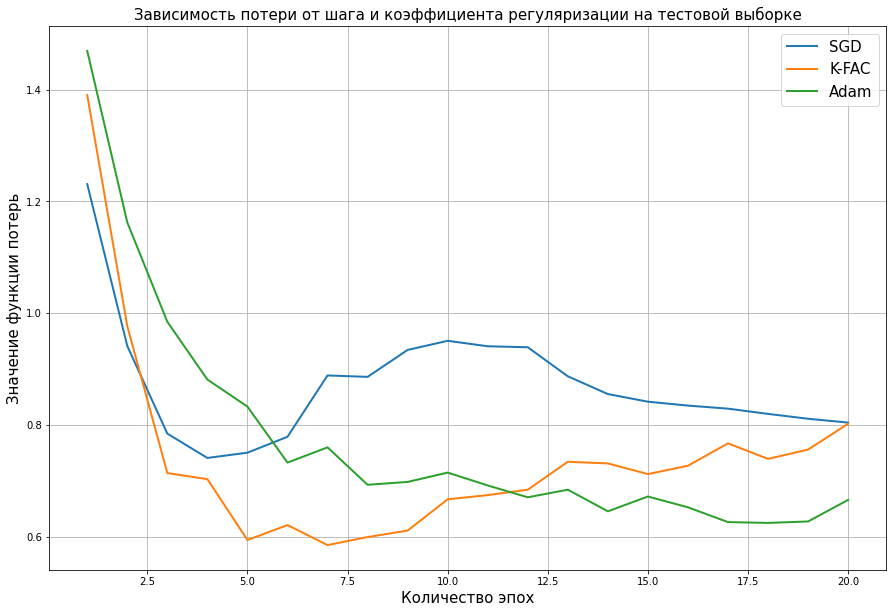

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)


plt.plot(range(1, 21), list(map(float, test_loss_history_sgd)), label = 'SGD', linewidth=2)
plt.plot(range(1, 21), list(map(float, test_loss_history_kfc)), label = 'K-FAC', linewidth=2)
plt.plot(range(1, 21), list(map(float, test_loss_history_adam)), label = 'Adam', linewidth=2)

plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('exp_2_loss.png')

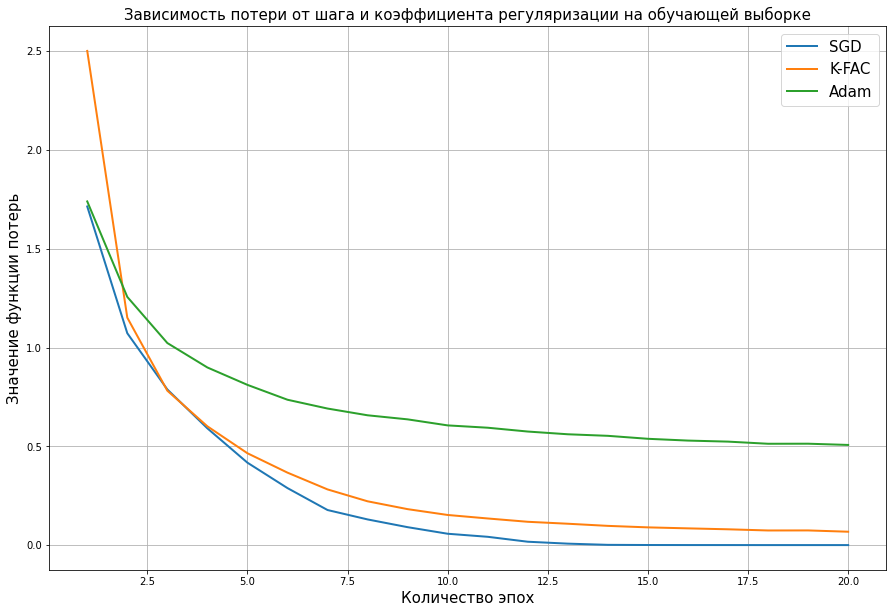

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)


plt.plot(range(1, 21), loss_in_training_sgd, label = 'SGD', linewidth=2)
plt.plot(range(1, 21), loss_in_training_kfc, label = 'K-FAC', linewidth=2)
plt.plot(range(1, 21), loss_in_training_adam, label = 'Adam', linewidth=2)

plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('exp_2_loss_train.png')

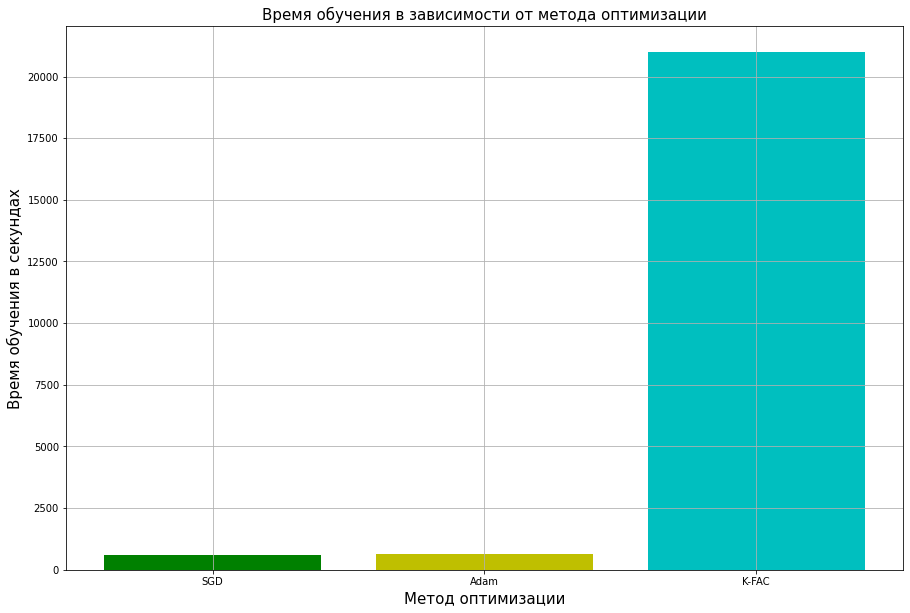

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Время обучения в зависимости от метода оптимизации', fontsize=15)
plt.xlabel('Метод оптимизации', fontsize=15)
plt.ylabel('Время обучения в секундах', fontsize=15)

x = ['SGD', 'Adam', 'K-FAC']
y = [sum(time_learning_sgd), sum(time_learning_adam), sum(time_learning_kfc)]

plt.bar(x, y, color = ['g', 'y', 'c'])

plt.grid(True)
plt.savefig('exp_2_time.png')

In [ ]:
import time

lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(lenet.parameters(), lr=0.1, weight_decay=0.001)
preconditioner = KFACPreconditioner(lenet)

test_loss_history_kfc = list()
test_accuracy_history_kfc = list()
loss_in_training_kfc = list()
time_learning_kfc = list()


for epoch in range(20):

    start_time = time.time()
    sum_los = 0

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        try:
            preconditioner.step()
            optimizer.step()
        except:
            print("Optimizer or preconditioner step failed")
            pass
        sum_los += float(loss_value)

    time_learning_kfc.append(time.time() - start_time)
    loss_in_training_kfc.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_kfc.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_kfc.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_kfc)
with open('kfc_bresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_kfc, "loss": test_loss_history_kfc, "loss_train":loss_in_training_kfc, "time":time_learning_kfc}, f)

In [ ]:
with open('kfc_results.pkl', 'rb') as f:
        arr = pickle.load(f)
kfc_acc = arr["kfc_acc"]
kfc_loss = arr["kfc_loss"]

FileNotFoundError: [Errno 2] No such file or directory: 'kfc_results.pkl'